This notebook was used to produce Table 2 of
>Anton Osokin, Anatole Chessel, Rafael E. Carazo Salas, Federico Vaggi<br>
GANs for Biological Image Synthesis<br>
In ICCV, 2017

In [1]:
import sys, os
import math
import numpy as np
import re
from PIL import Image
import pylab as plt

import torch
from torch.autograd import Variable
import torchvision.utils as vutils

sys.path.insert(0, '../../code')
import dcgan
from utils import pad_channels
from custom_dataloaders import read_image_for_pytorch

%matplotlib inline

In [2]:
models_wgan = '../../models/size-48-80_6class_wgangp-sep-adam/netG_iter_{0}.pth'
models_gan = '../../models/size-48-80_6class_gan-sep-adam/netG_iter_{0}.pth'
image_height = 48
image_width = 80
nz = 100
nc = 2
ngf = 64
red_portion = 0.5
iters_train = [1000, 5000, 50000]

In [3]:
def gen_noise(batch_size, nz):
    return torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)

def gen_separable_noise(batch_size, nz, red_portion, group_size=8):
    fixed_noise = gen_noise(batch_size, nz)
    n_red_noise = int(nz * red_portion)
    for i_group in range(math.ceil(batch_size / float(group_size))):
        group_start = i_group * group_size
        for i_element in range(1, min(group_size, batch_size - group_start)):
            fixed_noise[group_start + i_element, :n_red_noise] = fixed_noise[group_start, :n_red_noise]
    return fixed_noise

def generate_images(netG, noise):
    images = netG(Variable(noise)).data.cpu()
    images_01 = images * 0.5 + 0.5
    return images_01

def tensor_to_np(im):
    im = im.mul(255).clamp(0, 255).byte()
    if im.dim() == 3:
        im = im.permute(1, 2, 0)
    elif im.dim() == 4:
        im = im.permute(0, 2, 3, 1)
    return im.numpy()
    
def grid_to_image(grid):
    ndarr = tensor_to_np(grid)
    im = Image.fromarray(ndarr)
    return im

def show_images(im):
    fig, axes = plt.subplots(figsize=(15, 80))
    axes.imshow(im, interpolation='bilinear')
    axes.set_axis_off()

def show_cell_images(images_01, ncols=8):
    images_01 = pad_channels(images_01, 3, value=0)
    grid = vutils.make_grid(images_01, nrow=ncols, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
    im = grid_to_image(grid)
    show_images(im)

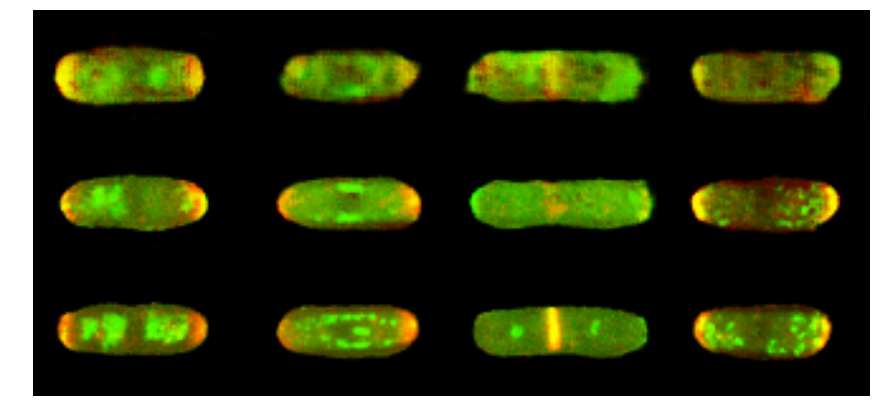

In [4]:
torch.manual_seed(42)
batch_size = 64
noise = gen_noise(batch_size, nz)

images_01_all = None

for iter in iters_train:
    network_path_wgan = models_wgan.format(iter)
    netG_wgan = dcgan.DCGAN_G((image_height, image_width), nz, nc, ngf, 0,red_portion=red_portion)
    netG_wgan.load_state_dict(torch.load(network_path_wgan))
    netG_wgan.cpu()
    netG_wgan.eval()
    images_01 = generate_images(netG_wgan, noise)
    images_01 = images_01[torch.LongTensor([57, 58, 24, 7])]
    if images_01_all is None:
        images_01_all = images_01
    else:
        images_01_all = torch.cat([images_01_all, images_01], 0)

images_01_all = pad_channels(images_01_all, 3, value=0)
show_cell_images(images_01_all, ncols=4)

vutils.save_image(images_01_all, 'figure3_wgangp_1000_5000_50000.png', nrow=4)

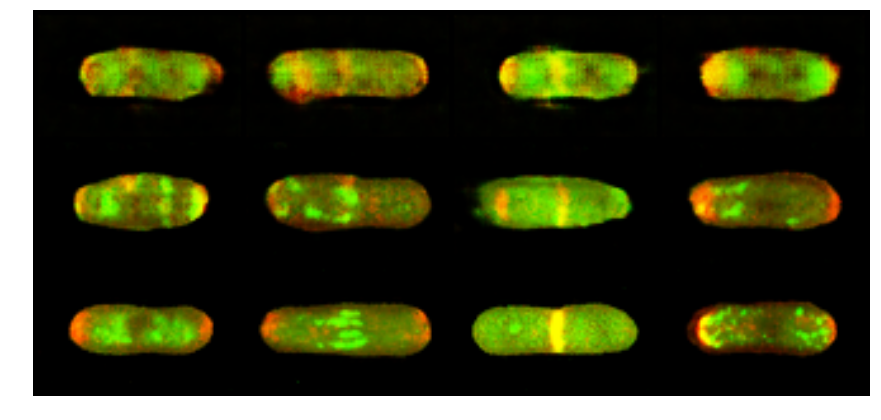

In [5]:
torch.manual_seed(1)
batch_size = 64
noise = gen_noise(batch_size, nz)

images_01_all = None

for iter in iters_train:
    network_path_gan = models_gan.format(iter)
    netG_gan = dcgan.DCGAN_G((image_height, image_width), nz, nc, ngf, 0,red_portion=red_portion)
    netG_gan.load_state_dict(torch.load(network_path_gan))
    netG_gan.cpu()
    netG_gan.eval()
    images_01 = generate_images(netG_gan, noise)
    images_01 = images_01[torch.LongTensor([32, 53, 30, 8])]
    if images_01_all is None:
        images_01_all = images_01
    else:
        images_01_all = torch.cat([images_01_all, images_01], 0)

images_01_all = pad_channels(images_01_all, 3, value=0)
show_cell_images(images_01_all, ncols=4)

vutils.save_image(images_01_all, 'figure3_gan_1000_5000_50000.png', nrow=4)

In [6]:
real_data_path = '../../data/LIN_Normalized_WT_size-48-80_6class_train'
real_cells = ['Cki2/cell100810.png',
              'Alp14/cell105766.png',
              'Sid2/cell101297.png',
              'Arp3/cell100134.png']

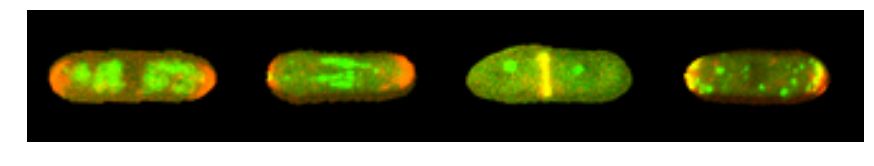

In [7]:
cells = []
for cell_name in real_cells:
    cell_path = os.path.join(real_data_path, cell_name)
    img = read_image_for_pytorch(cell_path)
    img = torch.from_numpy(img.astype(np.float32)) / 255.0
    cells.append(img)
cells = torch.stack(cells, 0)
show_cell_images(cells, ncols=4)
vutils.save_image(cells, 'figure3_real.png', nrow=4)

In [8]:
# real vs real estimates
def read_last_line(file_name):
    with open(file_name) as f:
        return(list(f)[-1])
    
def get_score(file_name):
    score = float('nan')
    try:
        last_line = read_last_line(file_name)
        numeric_const_pattern = "[-+]?(?:(?:\d*\.\d+)|(?:\d+\.?))(?:[Ee][+-]?\d+)?"
        score_pattern = 'equals\s*(%s)' % numeric_const_pattern
        match = re.search(score_pattern, last_line)
        if match:
            score = float(match.group(1))
    except:
        print('Could not extract value from {0}'.format(file_name))
    return score

log_path = 'logs_eval_6class-together_real_vs_real'
file_template = 'seed0_split{0}_evalWGAN-GP_iter5000.txt'

num_splits = 10
scores = []
for i_split in range(num_splits):
    file_name = os.path.join(log_path, file_template.format(i_split))
    score = get_score(file_name)
    scores.append(score)
scores = np.array(scores)
print('Mean =', np.mean(scores))
print('Std =', np.std(scores))

Mean = -0.727505996823
Std = 0.637706290882


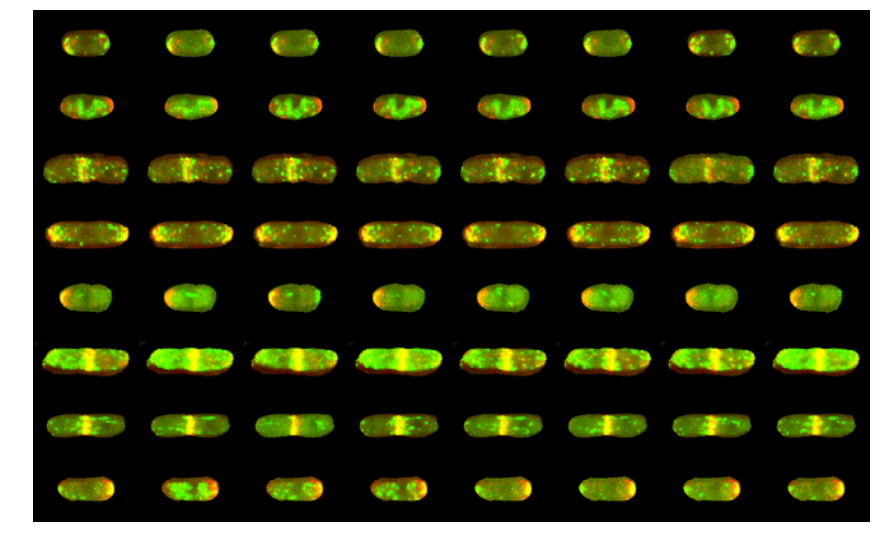

In [9]:
torch.manual_seed(6)
batch_size = 64
noise = gen_separable_noise(batch_size, nz, red_portion)

network_path_wgan = models_wgan.format(50000)
netG_wgan = dcgan.DCGAN_G((image_height, image_width), nz, nc, ngf, 0,red_portion=red_portion)
netG_wgan.load_state_dict(torch.load(network_path_wgan))
netG_wgan.cpu()
netG_wgan.eval()
images_01 = generate_images(netG_wgan, noise)
images_01 = pad_channels(images_01, 3, value=0)
show_cell_images(images_01, ncols=8)

vutils.save_image(images_01, 'figure4_wgangp_50000.png', nrow=8)

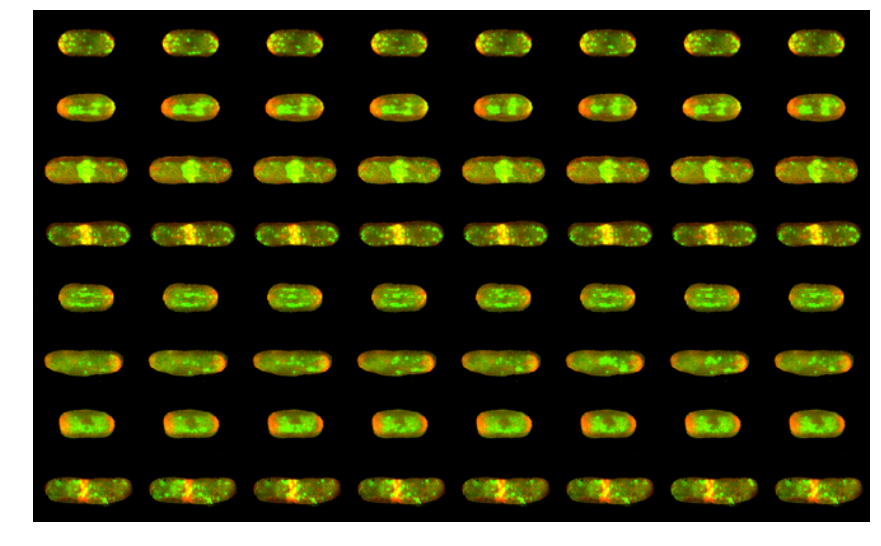

In [10]:
torch.manual_seed(10)
batch_size = 64
noise = gen_separable_noise(batch_size, nz, red_portion)

network_path_gan = models_gan.format(50000)
netG_gan = dcgan.DCGAN_G((image_height, image_width), nz, nc, ngf, 0,red_portion=red_portion)
netG_gan.load_state_dict(torch.load(network_path_gan))
netG_gan.cpu()
netG_gan.eval()
images_01 = generate_images(netG_gan, noise)
images_01 = pad_channels(images_01, 3, value=0)
show_cell_images(images_01, ncols=8)

vutils.save_image(images_01, 'figure4_gan_50000.png', nrow=8)